In [63]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# Custom module to create synthetic dataset
from utils.sine_dataset import signal_dataset_harmonic_creator

In [64]:
# LSTM parameters
hidden_dim = 20
n_signals = 1
N = 64
harmonics = 6
tagset_size = harmonics 


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [71]:
# Model creation
class LSTMHarmonic(nn.Module):
    """Some Information about LSTMHarmonic"""

    def __init__(self, N, hidden_dim, tagset_size):
        super(LSTMHarmonic, self).__init__()
        self.lstm = nn.LSTM(N, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        fc_layer = self.fc(lstm_out[:, -1, :])
        # output = self.softmax(fc_layer)

        return fc_layer
        


model = LSTMHarmonic(n_signals, hidden_dim, tagset_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
print(f"Model structure: {model}\n")

Model structure: LSTMHarmonic(
  (lstm): LSTM(1, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
)



In [72]:
# Define Dataset Class
# Define Dataset Class
class SineWaveDataset(torch.utils.data.Dataset):
    """Some Information about SineWaveDataset"""

    def __init__(self, signals, labels, transform=None, labels_transform=None):
        super(SineWaveDataset, self).__init__()
        self.signals = signals
        self.labels = labels
        self.transform = transform
        self.labels_transform = labels_transform

    def __getitem__(self, index):
        signal = self.signals[index]
        label = self.labels[index]
        if self.transform:
            signal = self.transform(signal)
        if self.labels_transform:
            label = self.labels_transform(label)
        return signal, label

    def __len__(self):
        return len(self.signals)

In [73]:
dataiter = iter(test_dataloader)
signal, labels = next(dataiter)
print(len(labels))
print(len(signal))


16
16


In [74]:
# Dataset Parameters
fs = 3840
N = 64
m = 10000

# Create Dataset Signals
signals, target = signal_dataset_harmonic_creator(
    fs, N, m, harmonics=harmonics, multiclass=True
)
signals = np.expand_dims(signals, axis=2)
signals = torch.from_numpy(signals).float()
target = torch.from_numpy(target).to(torch.int64)
# target_one_hot = nn.functional.one_hot(target.to(torch.int64))

# Create Dataset instance

dataset = SineWaveDataset(signals, target)
train_dataset, test_dataset, val_dataset = random_split(dataset, [0.9, 0.09, 0.01])
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)


In [75]:
# Create Training / Test / Validation Loops

# Training
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 40 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>f} [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred.argmax(1)) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )


In [76]:
epochs = 7
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n--------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)


Epoch 1
--------------------------------
loss: 1.767675 [    0/ 7501]
loss: 1.524015 [ 1280/ 7501]
loss: 1.379487 [ 2560/ 7501]
loss: 0.942586 [ 3840/ 7501]
loss: 0.944817 [ 5120/ 7501]
loss: 0.691004 [ 6400/ 7501]
Test Error: 
 Accuracy: 57.1%, Avg loss: 0.924493 

Epoch 2
--------------------------------
loss: 1.038088 [    0/ 7501]
loss: 0.660451 [ 1280/ 7501]
loss: 0.934141 [ 2560/ 7501]
loss: 0.478756 [ 3840/ 7501]
loss: 0.420506 [ 5120/ 7501]
loss: 0.576797 [ 6400/ 7501]
Test Error: 
 Accuracy: 90.1%, Avg loss: 0.338052 

Epoch 3
--------------------------------
loss: 0.424399 [    0/ 7501]
loss: 0.344992 [ 1280/ 7501]
loss: 0.277034 [ 2560/ 7501]
loss: 0.203023 [ 3840/ 7501]
loss: 0.092441 [ 5120/ 7501]
loss: 0.579524 [ 6400/ 7501]
Test Error: 
 Accuracy: 90.7%, Avg loss: 0.293417 

Epoch 4
--------------------------------
loss: 0.323990 [    0/ 7501]
loss: 0.450731 [ 1280/ 7501]
loss: 1.298569 [ 2560/ 7501]
loss: 0.738365 [ 3840/ 7501]
loss: 0.446968 [ 5120/ 7501]
loss: 0.23473

tensor([2, 0, 2, 5, 2, 1, 0, 0, 1])
torch.Size([16, 64, 1])
tensor([2, 0, 2, 5, 2, 1, 0, 0, 1])


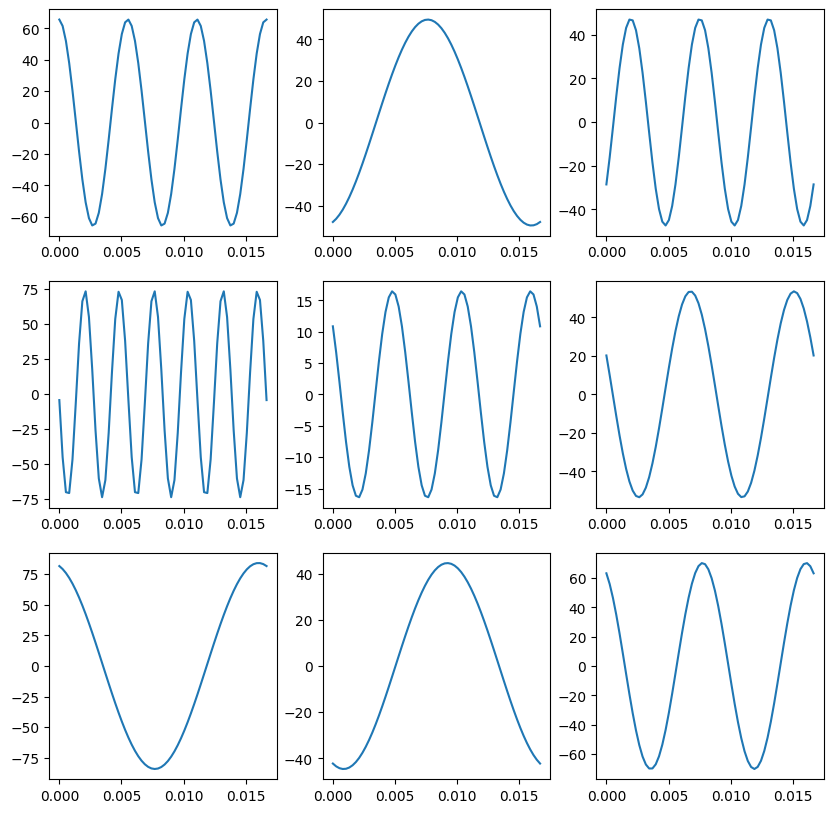

In [80]:
dataiter = iter(val_dataloader)
signal, labels = next(dataiter)
t = np.linspace(0, N / fs, N)
print(labels[1:10])
print(signal.shape)
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.plot(t, signal[i, :, 0])
x = model(signal[1:10].to(device))
print(nn.Softmax(dim=1)(x).argmax(1))